In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import tensorflow as tf

drive.mount('/content/drive')

# Fix OpenCV dependency in Colab
!apt-get install -y libgl1-mesa-glx

import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import os

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
# Enhanced feature extraction with vessel density
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Vessel detection
    edges = cv2.Canny(enhanced, 50, 150)
    vessel_density = np.mean(edges)

    # Texture features
    glcm = cv2.calcHist([enhanced], [0], None, [256], [0,256])
    glcm = cv2.normalize(glcm, None).flatten()

    # Shape features
    moments = cv2.HuMoments(cv2.moments(edges)).flatten()

    return [
        np.mean(enhanced),          # Global intensity
        np.std(enhanced),           # Contrast
        vessel_density,             # Edge density
        enhanced[200:300, 200:300].mean(),  # Center region
        glcm[100],                  # Texture measure
        moments[0],                 # Hu moment 1
        moments[1]                  # Hu moment 2
    ]

# Load data with average CDR and labels
# df = pd.read_csv('/content/drive/MyDrive/Glaucoma Detection/archive/glaucoma.csv')

df = pd.read_csv('/content/drive/MyDrive/datasets/ORIGA/glaucoma.csv')
df['cdr'] = df['ExpCDR']

# Feature extraction with augmentation
X, y, img_names, yy = [], [], [], []
# yy is the list of labels for all the data
for _, row in df.iterrows():
    # img_path = '/content/drive/MyDrive/Glaucoma Detection/archive/ORIGA/ORIGA/Images/'+row['Filename']
    img_path = '/content/drive/MyDrive/datasets/ORIGA/Images/'+row['Filename']
    feats = extract_features(img_path)
    if feats:
        X.append(feats)
        y.append(row['cdr'])
        yy.append(row['Glaucoma'])
        img_names.append(os.path.basename(img_path))

        # Data augmentation - horizontal flip
        img_flipped = cv2.flip(cv2.imread(img_path), 1)
        flipped_path = 'temp_flipped.jpg'
        cv2.imwrite(flipped_path, img_flipped)
        feats_flipped = extract_features(flipped_path)
        if feats_flipped:
            X.append(feats_flipped)
            y.append(row['cdr'])
            yy.append(row['Glaucoma'])
            img_names.append(os.path.basename(img_path) + '_flipped')

        os.remove(flipped_path)  # Clean up temp file


In [ ]:
# Feature selection
X = StandardScaler().fit_transform(X)
# resNet_features = StandardScaler().fit_transform(resNet_features)
selector = SelectKBest(mutual_info_regression, k=5)
X_selected = selector.fit_transform(X, y)

# Split data (keep track of image names)
X_train, X_test, y_train, y_test, img_names_train, img_names_test = train_test_split(
    X_selected, y, img_names,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [ ]:
# Training

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 10, None]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_absolute_error')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter tuning for SVR
svr_param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}
svr = SVR()
svr_grid = GridSearchCV(svr, svr_param_grid, cv=3, scoring='neg_mean_absolute_error')
svr_grid.fit(X_train, y_train)
best_svr = svr_grid.best_estimator_

# Ensemble model (VotingRegressor)
ensemble = VotingRegressor([
    ('rf', best_rf),
    ('svr', best_svr)
])

# ensemble.fit(resNet_features, y_train)
ensemble.fit(X_train, y_train)

# Evaluate
test_pred = ensemble.predict(X_test)
predicted_labels = (test_pred > 0.65).astype(int)
true_labels = (np.array(y_test) > 0.65).astype(int)

In [ ]:
# Evaluation

import csv
# save cdr values for whole dataset
cdr_predictons = ensemble.predict(X_selected)

# Print results
print("\n=== Enhanced Test Results ===")
print(f"{'Index':<6} | {'Image':<25} | {'Actual CDR':<10} | {'Predicted CDR':<12} | {'Actual Label':<12} | {'Predicted Label':<14} | {'Correct':<6}")
print("-" * 120)
correct_count = 0
for idx, (actual_cdr, pred_cdr, actual_label, pred_label, img_name) in enumerate(zip(y_test, test_pred, true_labels, predicted_labels, img_names_test)):
    correct = actual_label == pred_label
    correct_count += int(correct)
    print(f"{idx:<6} | {img_name:<25} | {actual_cdr:.4f}     | {pred_cdr:.4f}      | {actual_label:<12} | {pred_label:<14} | {'Yes' if correct else 'No'}")

# Calculate metrics
mae = mean_absolute_error(y_test, test_pred)
accuracy = accuracy_score(true_labels, predicted_labels)

print("\n=== Performance Metrics ===")
print(f"Test MAE (CDR): {mae:.4f}")
print(f"Label Accuracy: {accuracy:.2%}")
print(f"Optimal Threshold: 0.65")
print(f"Best RF Params: {rf_grid.best_params_}")
print(f"Best SVR Params: {svr_grid.best_params_}")


=== Enhanced Test Results ===
Index  | Image                     | Actual CDR | Predicted CDR | Actual Label | Predicted Label | Correct
------------------------------------------------------------------------------------------------------------------------
0      | 240.jpg                   | 0.5927     | 0.6128      | 0            | 0              | Yes
1      | 361.jpg_flipped           | 0.5648     | 0.5549      | 0            | 0              | Yes
2      | 157.jpg                   | 0.3305     | 0.4952      | 0            | 0              | Yes
3      | 331.jpg                   | 0.5313     | 0.5292      | 0            | 0              | Yes
4      | 412.jpg_flipped           | 0.3059     | 0.4969      | 0            | 0              | Yes
5      | 058.jpg_flipped           | 0.6342     | 0.5658      | 0            | 0              | Yes
6      | 451.jpg_flipped           | 0.5356     | 0.5376      | 0            | 0              | Yes
7      | 316.jpg_flipped           | 0.70

[0.6198912  0.61085354 0.60780841 ... 0.54801012 0.5753994  0.57779221]
Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       197
           1       0.00      0.00      0.00        63

    accuracy                           0.76       260
   macro avg       0.38      0.50      0.43       260
weighted avg       0.57      0.76      0.65       260


SVM Accuracy: 75.76923076923077


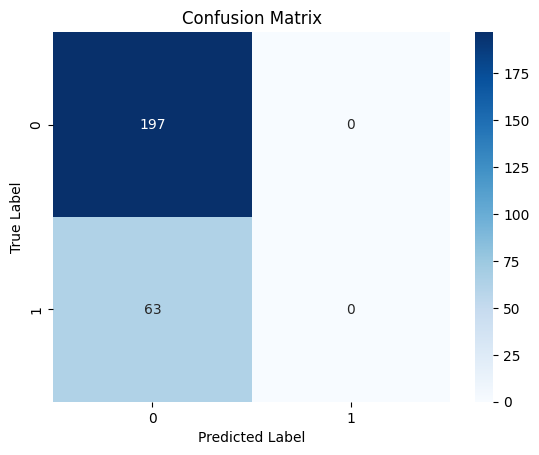

In [ ]:
print(cdr_predictons)

#SVM Classification
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
# print(df.shape)
# y = df['Glaucoma'].values
# features3 = cdr_predictions
# XX = cdr_predictions.reshape(-1, 1)
XX = X_selected

# add cdr values to the existing features
np.concatenate((XX, cdr_predictons.reshape(-1, 1)), axis=1)

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2)
# X_train = X_train.reshape(-1, 1)
from sklearn import svm, metrics
classifier = svm.SVC(gamma=0.001)
#fit to the trainin data
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))
from sklearn.metrics import accuracy_score, confusion_matrix
score = accuracy_score(y_test, y_pred)
from sklearn import metrics
print("SVM Accuracy:",accuracy_score(y_test,y_pred) * 100)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib

model_filename = 'svm_model.joblib'
joblib.dump(classifier, model_filename)

print(f"Model saved to {model_filename}")

In [ ]:
import os
import random
import joblib
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths to the directories
glaucoma_dir = "drive/MyDrive/datasets/ACRIMA/glaucoma/"
normal_dir = "drive/MyDrive/datasets/ACRIMA/normal/"

# Load the saved SVM model
model = joblib.load('svm_model.joblib')

# Function to get a random image from a directory
def get_random_image(directory):
    # List all PNG files in the directory
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]

    # Select a random image file
    random_file = random.choice(image_files)

    # Return the full path to the image
    return os.path.join(directory, random_file), random_file

# Function to preprocess the image for the model
def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale if needed
    # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to expected dimensions (adjust based on your model's requirements)
    img_resized = cv2.resize(img, (224, 224))

    # Normalize pixel values
    img_normalized = img_resized / 255.0

    # Flatten the image if your model expects a 1D vector
    # For HOG features or similar:
    # hog = cv2.HOGDescriptor()
    # features = hog.compute(img_resized)

    # For a simple flattened representation:
    features = img_normalized.flatten()

    return features

# Get random images from both directories
glaucoma_img_path, glaucoma_filename = get_random_image(glaucoma_dir)
normal_img_path, normal_filename = get_random_image(normal_dir)

# Display the selected images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(glaucoma_img_path))
plt.title(f"Glaucoma Image: {glaucoma_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(normal_img_path))
plt.title(f"Normal Image: {normal_filename}")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# Preprocess the images
glaucoma_features = extract_features(glaucoma_img_path)[:5]
normal_features = extract_features(normal_img_path)[:5]

glaucoma_features.append(int(ensemble.predict([glaucoma_features]) > 0.65))
normal_features.append(int(ensemble.predict([normal_features]) > 0.65))

glaucoma_features.pop()
normal_features.pop()
# Make predictions
glaucoma_prediction = model.predict([glaucoma_features])[0]
normal_prediction = model.predict([normal_features])[0]

# Display predictions
print(f"Prediction for glaucoma image: {glaucoma_prediction}")
print(f"Prediction for normal image: {normal_prediction}")
